Source: https://product-data-science.datamasked.com/courses/496549/lectures/9194647

## Goal

Being able to efficiently parse URLs and extract info from them is a very important skill for a data scientist.

Firstly, if you join a very early stage startup, it might be that a lot of data are just stored in the URLs visited by the users. And, therefore, you will have to build a system that parses the URLs, extracts fields out of it, and saves them into a table that can be easily queried (not the most fun of the jobs, but very useful!).

Secondly, often using external data can help a lot your models. And a way to get external data is by scraping websites. And this is often done by being able to play with a given site URL structure (assuming it is allowed by the external site ToS).

The goal of this project is to parse a sequence of URLs about user searches and extract some basic info out of it.

## Challenge Description

Company XYZ is a Online Travel Agent site, such as Expedia, Booking.com, etc.

They haven’t invested in data science yet and all the data they have about user searches are simply stored in the URLs the users generate when they search for a hotel. If you are not familiar with URLs, you can run a search on any OTA site and see how all search parameters are always present in the URL.

You are asked to:

1. Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values. For each search query, how many amenities were selected?

3. Often, to measure the quality of a search algorithm, data scientists use some metric based on how often users click on the second page, third page, and so on. The idea here is that a great search algorithm should return all interesting results on the first page and never force users to visit the other pages (how often do you click on the second page results when you search on Google? Almost never, right?).

Create a metric based on the above idea and find the city with the worst search algorithm.

### Load Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
with open('./data/url_list.txt') as f:
    lines = f.readlines()

print('Total records: ', len(lines))

Total records:  77677


In [3]:
def parse_data(lines):
    cols = ['checkin', 'checkout', 'customMinimumPriceFilter', 
                 'customMaximumPriceFilter', 'freeCancellation', 'stars_5', 
                 'stars_4', 'stars_3', 'stars_2', 'stars_1', 'max_score', 
                 'min_score', 'couponCode', 'adults', 'city', 'children', 
                 'amenities', 'search_page']
    maps = {}
    for col in cols:
        maps[col] = [np.nan] * len(lines)

    for i in range(len(lines)):
        line = lines[i]
        # get only the search items and values
        items = line.split('hotelsearch?')[1].strip().split('&')
        # split keyword and values
        for item in items:
            key, value = item.split('=')
            # remove the 'hotel.'
            key = key.split('.')[1]
            # according to the description, 'city' and 'amennities' may have multiple values
            if key in ['city', 'amenities']:
                value = value.replace('+', ' ')
            # add key and values in map
            maps[key][i] = value

    return maps, cols


def convert_to_dataframe(data, cols):
    # transform to dataframe
    df = pd.DataFrame(data, columns=cols)
    df['checkin'] = pd.to_datetime(df['checkin'])
    df['checkout'] = pd.to_datetime(df['checkout'])
    df = df.rename(columns={'customMinimumPriceFilter': 'MinPrice',
                            'customMaximumPriceFilter': 'MaxPrice'})
    return df

In [4]:
maps, cols = parse_data(lines)
df = convert_to_dataframe(maps, cols)
df.head()

,checkin,checkout,MinPrice,MaxPrice,freeCancellation,stars_5,stars_4,stars_3,stars_2,stars_1,max_score,min_score,couponCode,adults,city,children,amenities,search_page
0,2015-09-19,2015-09-20,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,4,NaN,3,"New York, NY, United States",NaN,NaN,1
1,2015-09-14,2015-09-15,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,4,NaN,3,"London, United Kingdom",NaN,NaN,1
2,2015-09-26,2015-09-27,NaN,175,NaN,NaN,yes,NaN,NaN,NaN,NaN,5,NaN,2,"New York, NY, United States",NaN,NaN,1
3,2015-09-02,2015-09-03,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN,4,NaN,1,"Hong Kong, Hong Kong",NaN,NaN,1
4,2015-09-20,2015-09-29,NaN,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,3,"London, United Kingdom",NaN,NaN,1


In [5]:
# check df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77677 entries, 0 to 77676
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   checkin           77677 non-null  datetime64[ns]
 1   checkout          77677 non-null  datetime64[ns]
 2   MinPrice          1270 non-null   object        
 3   MaxPrice          49288 non-null  object        
 4   freeCancellation  17949 non-null  object        
 5   stars_5           4303 non-null   object        
 6   stars_4           12704 non-null  object        
 7   stars_3           14862 non-null  object        
 8   stars_2           9931 non-null   object        
 9   stars_1           9323 non-null   object        
 10  max_score         5517 non-null   object        
 11  min_score         60826 non-null  object        
 12  couponCode        2221 non-null   object        
 13  adults            77677 non-null  object        
 14  city              7767

In [6]:
df.describe(include='all')

,checkin,checkout,MinPrice,MaxPrice,freeCancellation,stars_5,stars_4,stars_3,stars_2,stars_1,max_score,min_score,couponCode,adults,city,children,amenities,search_page
count,77677,77677,1270,49288,17949,4303,12704,14862,9931,9323,5517,60826,2221,77677,77677,260,704,77677
unique,29,48,6,6,1,1,1,1,1,1,2,5,1,4,4,2,6,10
top,2015-09-19 00:00:00,2015-09-20 00:00:00,150,175,yes,yes,yes,yes,yes,yes,5,4,yes,2,"New York, NY, United States",1,internet,1
freq,5279,6003,389,14569,17949,4303,12704,14862,9931,9323,5454,33639,2221,45922,29384,180,272,50000
first,2015-08-31 00:00:00,2015-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2015-09-28 00:00:00,2015-10-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This dataset looks good, no anomaly issue yet

In [7]:
mandatory = ['checkin', 'adults', 'city', 'checkout']
# check what criteria users search more
missing = df.isnull().sum().reset_index()
missing = missing.rename(columns={'index': 'criteria', 0:'missing_count'})
missing['ratio'] = missing['missing_count']/len(df)
# exclude mandatory values
missing[~missing['criteria'].isin(mandatory)].sort_values('ratio')

,criteria,missing_count,ratio
17,search_page,0,0.000000
11,min_score,16851,0.216937
3,MaxPrice,28389,0.365475
4,freeCancellation,59728,0.768928
7,stars_3,62815,0.808669
6,stars_4,64973,0.836451
8,stars_2,67746,0.872150
9,stars_1,68354,0.879977
10,max_score,72160,0.928975
5,stars_5,73374,0.944604


'min_score', 'MaxPrice' and 'freeCancellation' are the top3 search criteria for users.

### Question1

For each search query, how many amenities were selected

In [8]:
df['amenities'].value_counts()

internet       272
yes_smoking    170
shuttle        111
yes_pet         90
breakfast       39
lounge          22
Name: amenities, dtype: int64

In [9]:
df['amenities_count'] = df['amenities'].apply(lambda x: 0 if pd.isnull(x)
                                              else len(x.split(',')))
df['amenities_count'].value_counts()

0    76973
1      704
Name: amenities_count, dtype: int64

In [10]:
df['amenities'].unique()

array([nan, 'yes_smoking', 'shuttle', 'internet', 'yes_pet', 'breakfast',
       'lounge'], dtype=object)

So for each search, only 1 amenity selected.

### Question 2

Which city has the worst search algorithm, regarding the search page

In [11]:
df['search_page'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype=object)

In [12]:
df['first_page'] = df['search_page'].apply(lambda x: 0 if pd.isnull(x) else 1)
df['further_page'] = df['search_page'].apply(lambda x: 1 if int(x) > 1 else 0)
df.head()

,checkin,checkout,MinPrice,MaxPrice,freeCancellation,stars_5,stars_4,stars_3,stars_2,stars_1,...,min_score,couponCode,adults,city,children,amenities,search_page,amenities_count,first_page,further_page
0,2015-09-19,2015-09-20,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,...,4,NaN,3,"New York, NY, United States",NaN,NaN,1,0,1,0
1,2015-09-14,2015-09-15,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,...,4,NaN,3,"London, United Kingdom",NaN,NaN,1,0,1,0
2,2015-09-26,2015-09-27,NaN,175,NaN,NaN,yes,NaN,NaN,NaN,...,5,NaN,2,"New York, NY, United States",NaN,NaN,1,0,1,0
3,2015-09-02,2015-09-03,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,...,4,NaN,1,"Hong Kong, Hong Kong",NaN,NaN,1,0,1,0
4,2015-09-20,2015-09-29,NaN,275,NaN,NaN,NaN,NaN,NaN,NaN,...,5,NaN,3,"London, United Kingdom",NaN,NaN,1,0,1,0


In [31]:
city = df.groupby('city')['further_page'].mean().reset_index()
city = city.rename(columns={'further_page': 'further_page_ratio'})
city.sort_values('further_page_ratio', ascending=True)

,city,further_page_ratio
3,"San Francisco, California, United States",0.040715
0,"Hong Kong, Hong Kong",0.089174
2,"New York, NY, United States",0.442384
1,"London, United Kingdom",0.473412


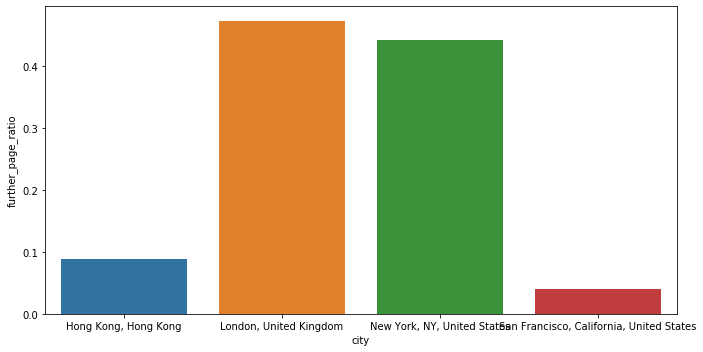

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='city', y='further_page_ratio', data=city, ax=ax)
plt.tight_layout()
plt.show()

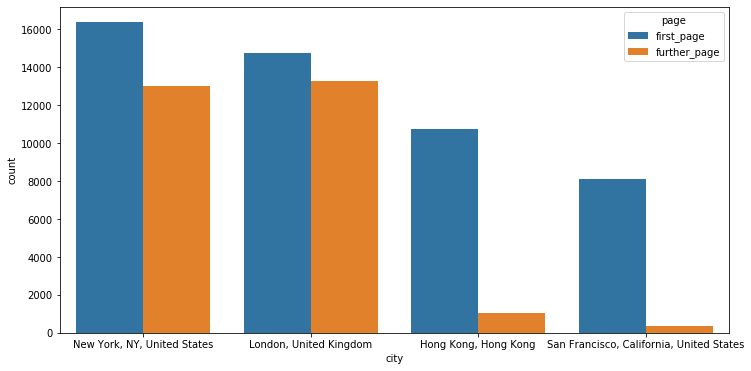

In [25]:
df['page'] = df['search_page'].apply(lambda x: 'first_page' if x == '1' else 'further_page')
fig, ax = plt.subplots(figsize = (12, 6))
sns.countplot(x='city', hue='page', data=df, ax=ax)
plt.show()

According to the graphs above, San Francisco and Hong Kong has the lowest further_page_ratio (below 0.1), so they have the worst search algorithms, the team should take a look into the search algorithms of these 2 cities.